In [33]:
# run_with_new_generator_star.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

# Typography / plot style (legends are mechanism names only)
mpl.rc('font', family='serif', serif=['Times New Roman'])
mpl.rcParams.update({
    'text.usetex': False,
    'font.size': 16,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'figure.titlesize': 20,
})
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 30

# --- NEW: data utilities (star model) ---
from data_utils_newest import (
    gen_star_from_x1,       # <-- star/hub generator
    get_true_frequencies,
    gen_progressive,

)
def list_all_correlations(df):
    """
    Return a DataFrame listing all pairwise Pearson correlations:
      Xi, Xj, correlation
    for all i < j.
    """
    cols = list(df.columns)
    results = []

    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            a, b = cols[i], cols[j]
            corr = df[a].astype(float).corr(df[b].astype(float))
            results.append((a, b, corr))

    return pd.DataFrame(results, columns=["Attr1", "Attr2", "PearsonCorr"])

# --- baselines ---
from metrics import compute_mse
from spl import random_split_perturb, random_split_estimate
from rs_fd import rs_fd_perturb, rs_fd_estimate
from rs_rfd import rs_rfd_perturb, rs_rfd_estimate

from corr_rr_fixed_new import (
    corr_rr_phase1_spl,
    corr_rr_phase2_perturb,
    corr_rr_estimate,
    combine_phase_estimates,
    optimal_p_y,
    build_p_y_table,
)

# ---------------- helpers ----------------

def pearson_corr_matrix(df):
    """
    Compute full pairwise Pearson correlation matrix
    across all attributes X1..Xd.
    """
    return df.astype(float).corr()

def _normalize_dist(d):
    vals = np.array([max(0.0, float(v)) for v in d.values()], dtype=float)
    s = vals.sum()
    if s <= 0:
        k = len(vals)
        vals = np.full(k, 1.0 / k)
    else:
        vals = vals / s
    return {k: vals[i] for i, k in enumerate(d.keys())}

def _build_p_y_table_minimal(est_I, epsilon, n2, domain, cols):
    return {
        (a, b): float(optimal_p_y(est_I[a], est_I[b], epsilon, n2, domain))
        for a in cols for b in cols if a != b
    }

# ---------------- one-shot runner ----------------
def run_all_once(
    df,
    epsilon,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,
):
    cols = list(df.columns)
    domains = {c: sorted(df[c].unique().tolist()) for c in cols}
    true_freqs = get_true_frequencies(df, cols)

    out = {}

    # SPL
    rpt = random_split_perturb(df, epsilon)
    est = random_split_estimate(rpt, df, epsilon)
    out["SPL"] = np.mean([compute_mse(true_freqs[c], est[c]) for c in cols])

    # RS+FD
    pert_rsfd = rs_fd_perturb(df, domains, epsilon)
    est_rsfd = rs_fd_estimate(pert_rsfd, domains, epsilon)
    out["RS+FD"] = np.mean([compute_mse(true_freqs[c], est_rsfd[c]) for c in cols])

    # RS+RFD (two-phase)
    est_I_rsrfd, df_B_rsrfd, doms_rsrfd = corr_rr_phase1_spl(df, epsilon, frac=frac_phase1_rsrfd)
    n1_rsrfd = len(df) - len(df_B_rsrfd)
    n2_rsrfd = len(df_B_rsrfd)
    priors_2p = {col: _normalize_dist(est_I_rsrfd[col]) for col in est_I_rsrfd}
    pert_rsrfd_2p = rs_rfd_perturb(df_B_rsrfd, doms_rsrfd, priors_2p, epsilon)
    est_II_rsrfd = rs_rfd_estimate(pert_rsrfd_2p, doms_rsrfd, priors_2p, epsilon)
    combined_rsrfd = combine_phase_estimates(est_I_rsrfd, est_II_rsrfd, n1_rsrfd, n2_rsrfd)
    out["RS+RFD"] = np.mean([compute_mse(true_freqs[c], combined_rsrfd[c]) for c in cols])

    # Corr-RR
    if use_corr_rr:
        est_I, df_B, doms_stable = corr_rr_phase1_spl(df, epsilon, frac=frac_phase1_corr)
        n1 = len(df) - len(df_B)
        n2 = len(df_B)
        common_domain = doms_stable[cols[0]]
        p_y_table = _build_p_y_table_minimal(est_I, epsilon, n2, common_domain, cols)
        pert_corr = corr_rr_phase2_perturb(df_B, epsilon, est_I, doms_stable, p_y_table)
        est_II = corr_rr_estimate(pert_corr, doms_stable, epsilon)
        combined_est = combine_phase_estimates(est_I, est_II, n1, n2)
        out["Corr-RR"] = np.mean([compute_mse(true_freqs[c], combined_est[c]) for c in cols])

    return out

def sweep_all(
    n=10000,
    epsilons=(0.2, 0.4, 0.6, 0.8, 1.0),
    R=50,
    corr=0.9,                 # global rho: every Xj (j>=2) correlates to X1
    d=4,                      # total attributes generated
    domain=None,
    x1_marginal=None,         # marginal p for X1 (and X1 only)
    q_marginal=None,          # None => uniform for non-copy branch
    plot_dir=None,
    csv_dir=None,
    seed=None,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,
):
    """
    Fixed-dataset sweep:
      - Generate ONE synthetic dataset using the star model.
      - Compute and print its Pearson correlation matrix.
      - Run all mechanisms multiple times on the SAME dataset.
    """

    # default settings
    if domain is None:
        domain = [0, 1]

    if x1_marginal is None:
        x1_marginal = {v: 1.0 / len(domain) for v in domain}

    keys = ["SPL", "RS+FD", "RS+RFD"] + (["Corr-RR"] if use_corr_rr else [])
    means = {k: np.zeros(len(epsilons)) for k in keys}

    if seed is not None:
        np.random.seed(seed)

    # =====================================================
    # 1) Generate ONE fixed dataset (critical change)
    # =====================================================
    df = gen_star_from_x1(
        n=n,
        domain=domain,
        d=d,
        x1_marginal=x1_marginal,
        rho=corr,
        q_marginal=q_marginal,
        seed=seed,    # ensures reproducibility
    )

    # =====================================================
    # 2) Compute and print true Pearson correlation matrix
    # =====================================================
    
    list_co = list_all_correlations(df)
    corr_mat = pearson_corr_matrix(df)
    dom = len(domain)
    # print("\n==============================================")
    # print(" Pearson Correlation Matrix (Progressive Data) ")
    # print("==============================================\n")
    # print(corr_mat)
    # print("\n")
    print("\n==============================================")
    print(" Pearson Correlation list of Synthetic Data ")
    print("==============================================\n")
    print(list_co)
    print("\n")
    print(dom)
    print(x1_marginal)
    # Save if directory is provided
    if csv_dir:
        os.makedirs(csv_dir, exist_ok=True)
        corr_mat.to_csv(os.path.join(csv_dir, "pearson_corr_matrix.csv"))

    # =====================================================
    # 3) Main sweep across epsilons
    # =====================================================
    for run in range(R):
        for j, eps in enumerate(epsilons):
            res = run_all_once(
                df,
                eps,
                use_corr_rr=use_corr_rr,
                frac_phase1_corr=frac_phase1_corr,
                frac_phase1_rsrfd=frac_phase1_rsrfd,
            )
            for k in keys:
                means[k][j] += res[k]

    for k in keys:
        means[k] /= R

    # =====================================================
    # 4) Plotting
    # =====================================================
    plt.figure(figsize=(10, 8))
    plt.plot(epsilons, means["SPL"],         '-o', linewidth=3, markersize=16, label='SPL')
    plt.plot(epsilons, means["RS+FD"],       '-s', linewidth=3, markersize=16, label='RS+FD')
    plt.plot(epsilons, means["RS+RFD"],      '-^', linewidth=3, markersize=16, label='RS+RFD')
    if use_corr_rr:
        plt.plot(epsilons, means["Corr-RR"], '-D', linewidth=3, markersize=16, label='Corr-RR')

    plt.xlabel(r'$ϵ$', fontsize=50)
    plt.ylabel('MSE',  fontsize=40)
    plt.xticks(epsilons, labels=[str(e) for e in epsilons])
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    plt.legend(fontsize=35, loc='upper right', frameon=True, edgecolor='black')
    plt.tight_layout()

    # Save plot
    def _fmt(x): return f"{x:g}"
    base = f"mseVSepsilon_{d}attr_{len(domain)}domain_n_{n}_rho_{_fmt(corr)}"

    if plot_dir:
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, base + ".pdf"), format="pdf")

    plt.show()

    # Save MSE results
    if csv_dir:
        df_out = pd.DataFrame({"epsilon": list(epsilons)})
        for k in keys:
            df_out[k] = means[k]
        df_out.to_csv(os.path.join(csv_dir, base + ".csv"), index=False)

    return means


def sweep_all_progressive(
    n=10000,
    epsilons=(0.2, 0.4, 0.6, 0.8, 1.0),
    R=50,
    rho=0.9,                 # global copy probability
    d=4,                     # total attributes
    domain=None,
    x1_marginal=None,
    q_marginal=None,
    plot_dir=None,
    csv_dir=None,
    seed=None,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,
):
    """
    Fixed-dataset sweep for the PROGRESSIVE dependency model:
      - Generate ONE synthetic dataset using gen_progressive().
      - Print its Pearson correlation matrix.
      - Run all mechanisms multiple times on that SAME dataset.
    """

    # -------------------------------
    # defaults
    # -------------------------------
    if domain is None:
        domain = [0, 1]

    if x1_marginal is None:
        x1_marginal = {v: 1.0 / len(domain) for v in domain}

    keys = ["SPL", "RS+FD", "RS+RFD"] + (["Corr-RR"] if use_corr_rr else [])
    means = {k: np.zeros(len(epsilons)) for k in keys}

    if seed is not None:
        np.random.seed(seed)

    # =========================================================
    # 1) Generate ONE fixed progressive dataset
    # =========================================================
    df = gen_progressive(
        n=n,
        domain=domain,
        d=d,
        x1_marginal=x1_marginal,
        rho=rho,
        q_marginal=q_marginal,
        seed=seed
    )
    # =========================================================
    # 2) Compute & print true Pearson correlation matrix
    # =========================================================
    list_co = list_all_correlations(df)
    corr_mat = pearson_corr_matrix(df)
    dom = len(domain)
    # print("\n==============================================")
    # print(" Pearson Correlation Matrix (Progressive Data) ")
    # print("==============================================\n")
    # print(corr_mat)
    # print("\n")
    print("\n==============================================")
    print(" Pearson Correlation list of Synthetic Data ")
    print("==============================================\n")
    print(list_co)
    print("\n")
    print(dom)
    print(x1_marginal)
    

    if csv_dir:
        os.makedirs(csv_dir, exist_ok=True)
        corr_mat.to_csv(os.path.join(csv_dir, "pearson_corr_matrix_progressive.csv"))

    # =========================================================
    # 3) Sweep all mechanisms on the SAME dataset
    # =========================================================
    for run in range(R):
        for j, eps in enumerate(epsilons):
            res = run_all_once(
                df,
                eps,
                use_corr_rr=use_corr_rr,
                frac_phase1_corr=frac_phase1_corr,
                frac_phase1_rsrfd=frac_phase1_rsrfd,
            )
            for k in keys:
                means[k][j] += res[k]

    for k in keys:
        means[k] /= R

    # =========================================================
    # 4) Plotting
    # =========================================================
    plt.figure(figsize=(10, 8))
    plt.plot(epsilons, means["SPL"],         '-o', linewidth=3, markersize=16, label='SPL')
    plt.plot(epsilons, means["RS+FD"],       '-s', linewidth=3, markersize=16, label='RS+FD')
    plt.plot(epsilons, means["RS+RFD"],      '-^', linewidth=3, markersize=16, label='RS+RFD')
    if use_corr_rr:
        plt.plot(epsilons, means["Corr-RR"], '-D', linewidth=3, markersize=16, label='Corr-RR')

    plt.xlabel(r'$ϵ$', fontsize=50)
    plt.ylabel('MSE',  fontsize=40)
    plt.xticks(epsilons, labels=[str(e) for e in epsilons])
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    plt.legend(fontsize=35, loc='upper right', frameon=True, edgecolor='black')
    plt.tight_layout()

    base = f"mseVSepsilon_progressive_{d}attr_{len(domain)}domain_n_{n}_rho_{rho}"

    if plot_dir:
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, base + ".pdf"), format="pdf")

    plt.show()

    if csv_dir:
        df_out = pd.DataFrame({"epsilon": list(epsilons)})
        for k in keys:
            df_out[k] = means[k]
        df_out.to_csv(os.path.join(csv_dir, base + ".csv"), index=False)

    return means


In [54]:

domain = [0, 1, 2, 3]  # same domain for all attributes

# Marginals for odd attributes
x1_marginal = {0: 0.4, 1: 0.3, 2: 0.2, 3: 0.1} 
epsilon=[0.1,0.2,0.3,0.4,0.5]
d = 4

rho=0.92 # when we want 0.9 for dataset1
# rho=0.54 # when we want 0.5 for dataset1
# rho=0.117 # when we want 0.1 for dataset1
corr=rho
n = 20000
R = 50


if __name__ == "__main__":
    
    
    means = sweep_all(
        n=n, epsilons=epsilon, R=R, corr=corr,
        seed=42, use_corr_rr=True, domain = domain, x1_marginal= x1_marginal,
        frac_phase1_corr=0.2, frac_phase1_rsrfd=0.2,
        plot_dir=r"C:\\Users\\ss6365\\Desktop\\pets_6_nov",
        csv_dir=r"C:\\Users\\ss6365\\Desktop\\pets_6_nov\\data"
    )


 Pearson Correlation list of Synthetic Data 

  Attr1 Attr2  PearsonCorr
0    X1    X2     0.900500
1    X1    X3     0.904727
2    X1    X4     0.909209
3    X2    X3     0.813339
4    X2    X4     0.819817
5    X3    X4     0.822586


4
{0: 0.4, 1: 0.3, 2: 0.2, 3: 0.1}


KeyboardInterrupt: 


 Pearson Correlation list of Synthetic Data 

  Attr1 Attr2  PearsonCorr
0    X1    X2     0.488403
1    X1    X3     0.507651
2    X1    X4     0.501922
3    X2    X3     0.252254
4    X2    X4     0.240398
5    X3    X4     0.248076


4
{0: 0.4, 1: 0.3, 2: 0.2, 3: 0.1}


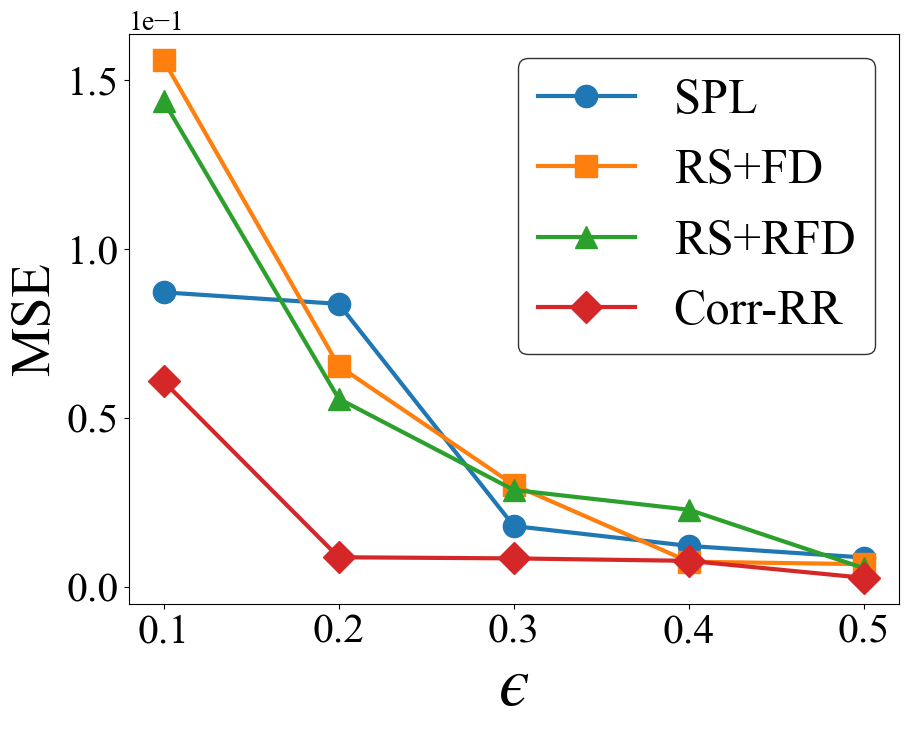

In [55]:

domain = [0, 1, 2, 3]  # same domain for all attributes

# Marginals for odd attributes
x1_marginal = {0: 0.4, 1: 0.3, 2: 0.2, 3: 0.1} 
epsilon=[0.1,0.2,0.3,0.4,0.5]
d = 4

#rho=0.92 # when we want 0.9 for dataset1
rho=0.54 # when we want 0.5 for dataset1
# rho=0.117 # when we want 0.1 for dataset1
corr=rho
n = 20000
R = 1


if __name__ == "__main__":
    
    
    means = sweep_all(
        n=n, epsilons=epsilon, R=R, corr=corr,
        seed=42, use_corr_rr=True, domain = domain, x1_marginal= x1_marginal,
        frac_phase1_corr=0.2, frac_phase1_rsrfd=0.2,
        # plot_dir=r"C:\\Users\\ss6365\\Desktop\\pets_6_nov",
        # csv_dir=r"C:\\Users\\ss6365\\Desktop\\pets_6_nov\\data"
    )


 Pearson Correlation list of Synthetic Data 

  Attr1 Attr2  PearsonCorr
0    X1    X2     0.107307
1    X1    X3     0.100319
2    X1    X4     0.105987
3    X2    X3     0.007122
4    X2    X4     0.021502
5    X3    X4     0.017806


4
{0: 0.4, 1: 0.3, 2: 0.2, 3: 0.1}


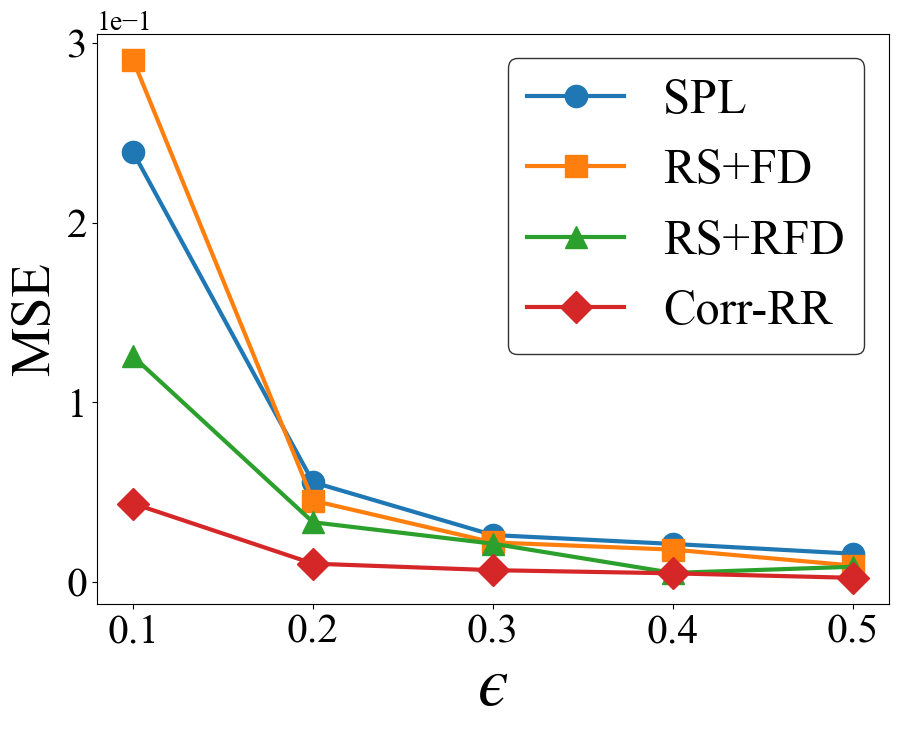

In [56]:

domain = [0, 1, 2, 3]  # same domain for all attributes

# Marginals for odd attributes
x1_marginal = {0: 0.4, 1: 0.3, 2: 0.2, 3: 0.1} 
epsilon=[0.1,0.2,0.3,0.4,0.5]
d = 4

#rho=0.92 # when we want 0.9 for dataset1
#rho=0.54 # when we want 0.5 for dataset1
rho=0.117 # when we want 0.1 for dataset1
corr=rho
n = 20000
R = 1


if __name__ == "__main__":
    
    
    means = sweep_all(
        n=n, epsilons=epsilon, R=R, corr=corr,
        seed=42, use_corr_rr=True, domain = domain, x1_marginal= x1_marginal,
        frac_phase1_corr=0.2, frac_phase1_rsrfd=0.2,
        # plot_dir=r"C:\\Users\\ss6365\\Desktop\\pets_6_nov",
        # csv_dir=r"C:\\Users\\ss6365\\Desktop\\pets_6_nov\\data"
    )

In [51]:
# # === Data spec ===
# domain = [0, 1, 2, 3]  # same domain for all attributes

# # Marginals for odd attributes
# x1_marginal = {0: 0.4, 1: 0.3, 2: 0.2, 3: 0.1} 
# epsilon=[0.1,0.2,0.3,0.4,0.5]
# d = 4

# rho=0.92 # when we want 0.9 for dataset2
# rho=0.54 # when we want 0.5 for dataset2
# rho=0.117 # when we want 0.1 for dataset2
# corr=rho
# n = 20000
# R = 1
# means = sweep_all_progressive(
#     n=n,
#     R=R,
#     rho=rho,
#     d=d,
#     domain = domain,
#     x1_marginal = x1_marginal,
#     epsilons = epsilon,
#     seed=42,
#     #plot_dir=r"C:\\Users\\ss6365\\Desktop\\pets_revised_figures",
#     #csv_dir=r"C:\\Users\\ss6365\\Desktop\\pets_revised_figures\\data"
# )



 Pearson Correlation list of Synthetic Data 

  Attr1 Attr2  PearsonCorr
0    X1    X2     0.107307
1    X1    X3     0.100319
2    X1    X4     0.105987
3    X2    X3     0.007122
4    X2    X4     0.021502
5    X3    X4     0.017806


4
{0: 0.4, 1: 0.3, 2: 0.2, 3: 0.1}


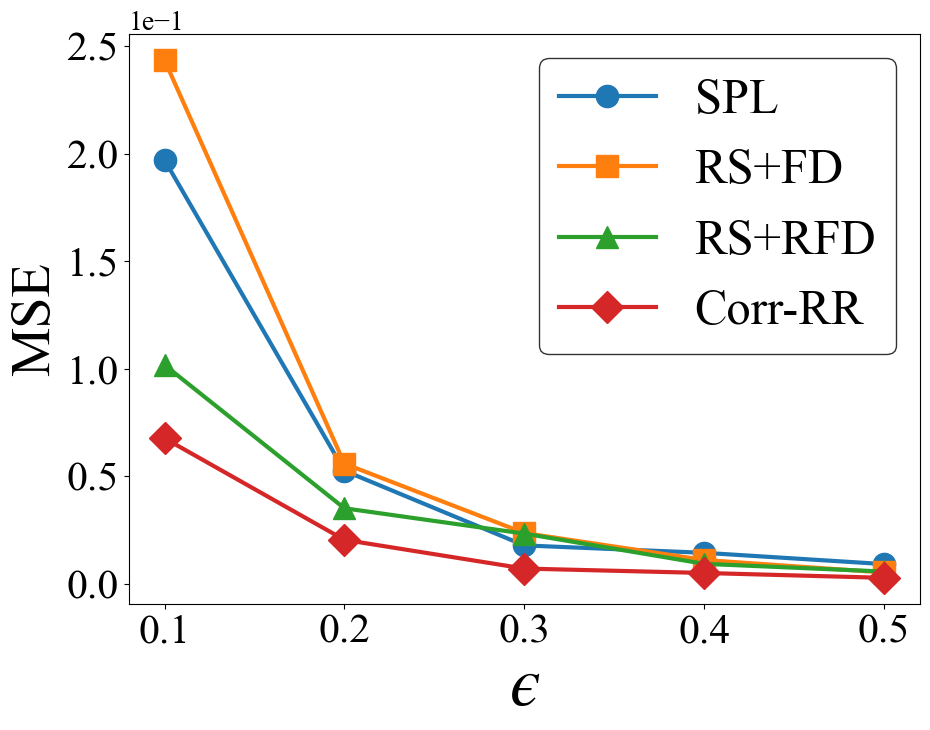

In [58]:

domain = [0, 1, 2, 3]  # same domain for all attributes

# Marginals for odd attributes
x1_marginal = {0: 0.4, 1: 0.3, 2: 0.2, 3: 0.1} 
epsilon=[0.1,0.2,0.3,0.4,0.5]
d = 4

#rho=0.92 # when we want 0.9 for dataset1
#rho=0.54 # when we want 0.5 for dataset1
rho=0.117 # when we want 0.1 for dataset1
corr=rho
n = 20000
R = 5


if __name__ == "__main__":
    
    
    means = sweep_all(
        n=n, epsilons=epsilon, R=R, corr=corr,
        seed=42, use_corr_rr=True, domain = domain, x1_marginal= x1_marginal,
        frac_phase1_corr=0.2, frac_phase1_rsrfd=0.2,
        # plot_dir=r"C:\\Users\\ss6365\\Desktop\\pets_6_nov",
        # csv_dir=r"C:\\Users\\ss6365\\Desktop\\pets_6_nov\\data"
    )


 Pearson Correlation list of Synthetic Data 

  Attr1 Attr2  PearsonCorr
0    X1    X2     0.900500
1    X1    X3     0.904727
2    X1    X4     0.909209
3    X2    X3     0.813339
4    X2    X4     0.819817
5    X3    X4     0.822586


4
{0: 0.4, 1: 0.3, 2: 0.2, 3: 0.1}


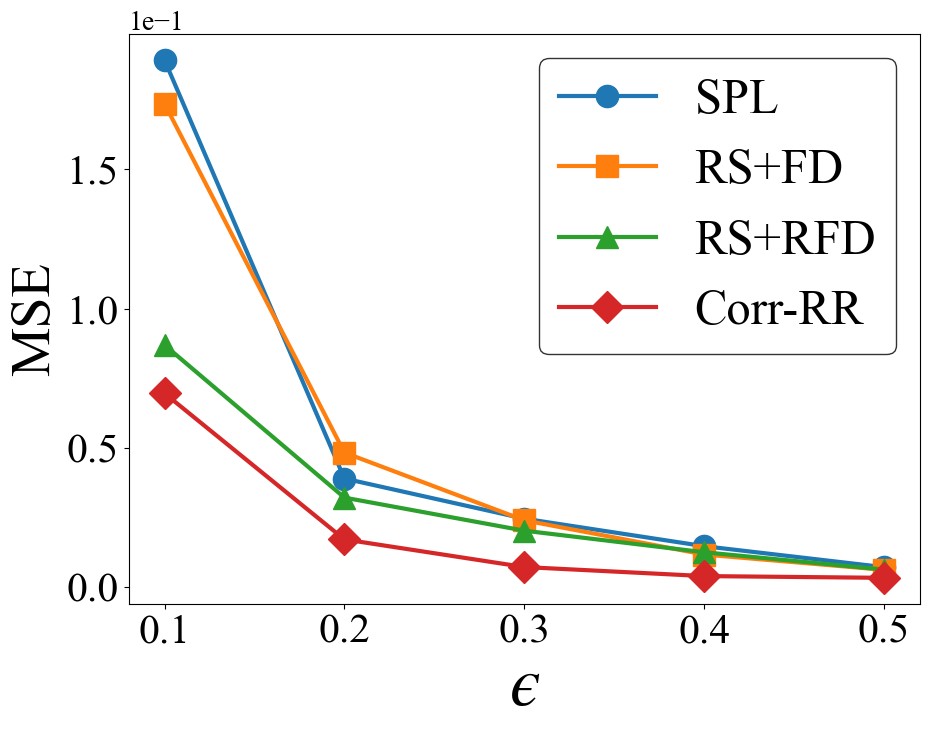

In [59]:

domain = [0, 1, 2, 3]  # same domain for all attributes

# Marginals for odd attributes
x1_marginal = {0: 0.4, 1: 0.3, 2: 0.2, 3: 0.1} 
epsilon=[0.1,0.2,0.3,0.4,0.5]
d = 4

rho=0.92 # when we want 0.9 for dataset1
#rho=0.54 # when we want 0.5 for dataset1
#rho=0.117 # when we want 0.1 for dataset1
corr=rho
n = 20000
R = 5


if __name__ == "__main__":
    
    
    means = sweep_all(
        n=n, epsilons=epsilon, R=R, corr=corr,
        seed=42, use_corr_rr=True, domain = domain, x1_marginal= x1_marginal,
        frac_phase1_corr=0.2, frac_phase1_rsrfd=0.2,
        # plot_dir=r"C:\\Users\\ss6365\\Desktop\\pets_6_nov",
        # csv_dir=r"C:\\Users\\ss6365\\Desktop\\pets_6_nov\\data"
    )

0.117